# Integrated tests for alignment result

This notebook provides an example of how to use our library to analyze a mutagenesis library of which the sequencing data of consensus reads are saved as a fastq.gz file.

**Package dependency:**

numpy
pandas
gzip
Bio.SeqIO
Bio.Seq
Bio.Align
intertools.islice
csv
ast
matplotlib
seaborn

In [1]:
import numpy as np
import pandas as pd
import gzip
from Bio import SeqIO
from itertools import islice
import csv
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mutan.mutalign as mutalign
import mutan.mutio as mutio
import mutan.mutAA as mutAA
import mutan.mutlib as mutlib
import mutan.mutmatrix as mutmatrix
import mutan.plot_settings

In [3]:
# Specify the wild type sequence of the mutagenesis library. 
# The output of the mutio.fasta_to_seq function is a Bio.Report.Report object.
# It is important to extract the .seq attribute using '.seq' suffix
target = mutio.fasta_to_seq('wtesta_p20m20.fasta').seq
target_AA = mutAA.translate_target_aa(target)

/Users/anqichen/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [24]:
def nt_mut(wt_nt):
    """
    Function to simulate a single NT point mutation
    
    Input: 
    wt_nt: char, one of agct or AGCT.
    
    Output:
    mt_nt: char, upper case A or G or C or T, representing a mutated nt.
    """
    rand_number=np.random.randint(low=1, high=4)
    nts = 'agct'.upper() # standardize nts to upper case
    wt_nt=wt_nt.upper() # standardize the wt_nt to upper case
    for i,nt in enumerate(nts):
        if wt_nt == nt:
            wt_nt=i
    mt_nt= nts[(wt_nt+rand_number)%4].upper()
    
    return mt_nt

In [47]:
def seq_mut(wt_seq, wt_locs):
    """
    function to simulate a number of NT point mutations at positions indicated by wt_locs
    
    input: wt_seq -- bio.seq.seq, wild type sequence
    wt_locs: int list or numpy array or other iterables of integers -- NT locations to introduce mutation
    """
    for wt_loc in wt_locs:
        wt_nt=wt_seq[wt_loc]
        mt_nt=nt_mut(wt_nt)
        wt_seq=wt_seq[:wt_loc]+mt_nt+wt_seq[wt_loc+1:]
    
    return wt_seq

In [52]:
# unit test for seq_mut

locs=np.random.randint(low=23, high=563+1,size=3)
test_mut=seq_mut(target, locs)
# assert the three mutations are correctly picked out
# assert that the mutations all result in single NT substitutions from the wt to a different NT
print(mutalign.align_DNA(query=test_mut, target=target))
print(locs)

{'sequence': Seq('GGATAGAGGTAAAGGAATTCATGGAACACAACCCGGTTGTAATGCTTCATGGTA...GGG'), 'read_length': 583, 'alignment_start': 1, 'alignment_length': 583, 'insertions': [], 'num_insertions': 0, 'deletions': [], 'num_deletions': 0, 'substitutions': ['G44C', 'T69G', 'T423C'], 'num_substitutions': 3, 'strand': 'forward'}
[423  44  69]


In [ ]:
np.random.randint(low=23, high=563+1,size=3)

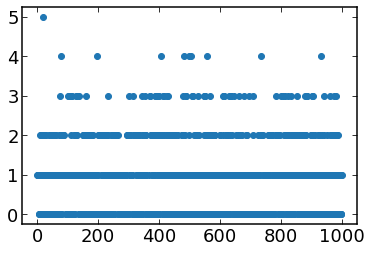

In [63]:
num_substitutions=np.random.poisson(1,size =library_size)
plt.plot(num_substitutions ,'o')

In [79]:
# Simulate an error prone library of size 1000, with a mean error rate of 5 per seq

def simulate_library(library_size=1000, 
                     start_codon_pos=20, 
                     end_codon_pos=563, 
                     random_mutation_rate=False, 
                     mutation_rate=5):

    num_substitutions=mutation_rate*np.ones(library_size)

    if random_mutation_rate:
        # sample the number of mutations, N in the mutant, using a Poisson statistics with a mean of poisson_mean
        num_substitutions=np.random.poisson(mutation_rate,size =library_size)

    # sample the mutation locations of these N mutations.
    mutants=[]
    for num in num_substitutions:
        substitution_locs=np.random.randint(low=start_codon_pos+3, high=end_codon_pos+1,size=int(num))
        # generate the sequence
        mutants.append(seq_mut(target, substitution_locs))
    return mutants

library_size=1000
start_codon_pos=20
end_codon_pos=563

mutants=simulate_library(library_size=library_size, 
                     start_codon_pos=start_codon_pos, 
                     end_codon_pos=end_codon_pos, 
                     random_mutation_rate=True, 
                     mutation_rate=5)

In [80]:
# Save simulated library as a .fastq.gz file
def save_mutants(mutants, output_file_name):
    with gzip.open(output_file_name, "wt") as gz_handle:
        for seq_id, mutant in enumerate(mutants):
            qualities = [37] * len(mutant)  # Assigning a default quality score of 37 to each base. Using "phred_quality" for quality input requires a list of floats to represent per base quality.
            seq_record = SeqIO.SeqRecord(mutant,name=f"Mutant_{seq_id}", id=f"Mutant_{seq_id}", description=f"Mutant_{seq_id}", letter_annotations={"phred_quality": qualities})
            SeqIO.write(seq_record, gz_handle, "fastq")
            
# simulated_single_lib_file_name='simulated_single_lib.fastq.gz'
simulated_epPCR5_lib_file_name='simulated_epPCR5_lib.fastq.gz'
save_mutants(mutants, simulated_epPCR5_lib_file_name)

In [81]:
# Perform sequence alignment on a number of reads in the .fastq.gz file to the target WT sequence.
# The alignment information is saved in a .csv file.
# This step is the most time-consuming step of the entire analysis process. Therefore we run it only once,
# and then comment this cell out after we have saved a test .csv file for the rest of this Jupyter Notebook.
# file_path="simulated_alignment.fastq.gz"

mutalign.align_DNA_write_to_csv(input_file=simulated_epPCR5_lib_file_name,
                                output_file='simulated_epPCR5_lib.csv',
                                target=target,
                                set_num_iterations=False)

100 iterations done
200 iterations done
300 iterations done
400 iterations done
500 iterations done
600 iterations done
700 iterations done
800 iterations done
900 iterations done
1000 iterations done


In [82]:
# Read in the alignment .csv file and post process to append AA-level mutation information. This
# step generates the mutation dataframe that contains all information needed for our analysis.
# df=mutAA.AA_analaysis_for_DNA_alignment(target=target,input_file='simulated_alignment.csv', output_file='simulated_alignment_AA.csv')

df=mutAA.AA_analaysis_for_DNA_alignment(target=target,input_file='simulated_epPCR5_lib.csv', output_file='simulated_epPCR5_lib_AA.csv')

/Users/anqichen/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [83]:
# Check the columns in mutation dataframe
df.columns

Index(['sequence', 'read_length', 'alignment_start', 'alignment_length',
       'insertions', 'num_insertions', 'deletions', 'num_deletions',
       'substitutions', 'num_substitutions', 'strand', 'sequence_id',
       'quality', 'AA_translation', 'AA_length', 'num_rare_codons',
       'AA_substitutions', 'num_AA_substitutions',
       'AA_substitution_positions'],
      dtype='object')

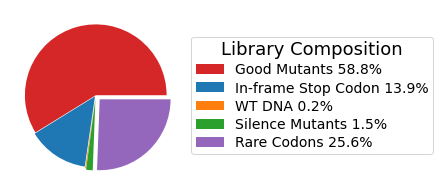

In [84]:
# In the raw alignment dataframe, filter out the reads where the DNA alignment length is the same as the input
# target WT DNA sequence, and no insertions or deletions were detected. 

# Define effective DNA library

df_effective_DNAlib=mutlib.effective_DNAlib(df, target)

# Calcuate the composition of the library, which includes the fraction of good mutatns, in-frame stop codons, wt DNA and silence mutants, as well as rare codons in the library.
lib_comp = mutlib.library_composition(df_effective_DNAlib, target)

# Plot library_composition as a pie chart. The pie chart only includes reads with 
mutlib.plot_library_composition(lib_comp, figname=None)

In [85]:
# Define effective DNA library by taking the original df and filtering out the reads where the DNA alignment length is the same as the input
# target WT DNA sequence, and no insertions or deletions were detected. 
df_effective_AAlib=mutlib.effective_AAlib(df, target)

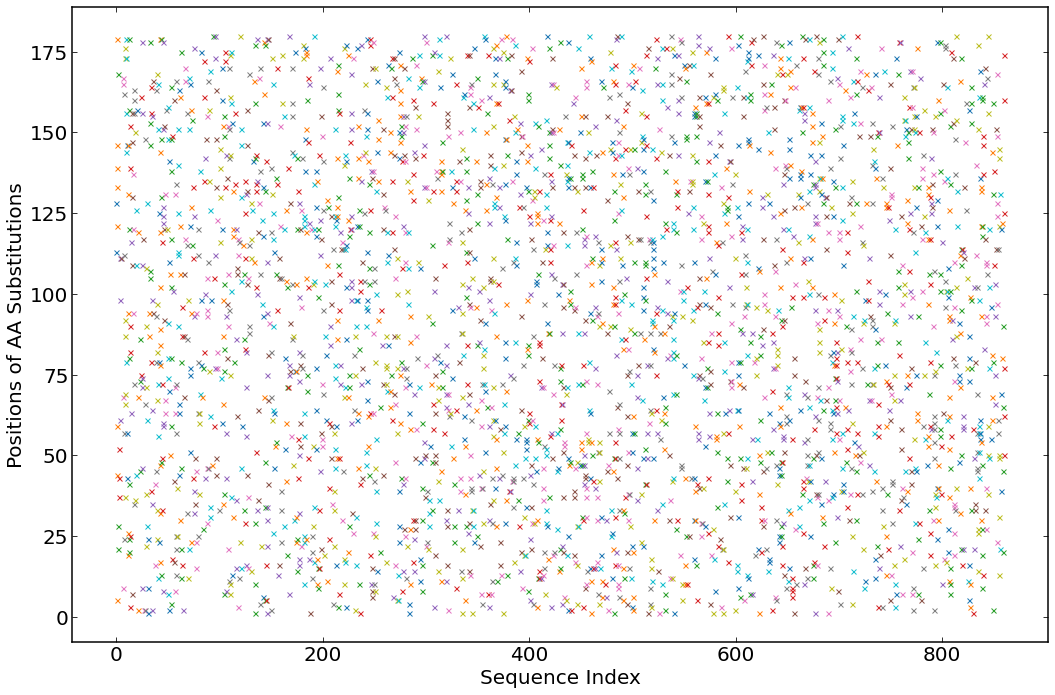

In [86]:
# Plot the AA mutations found in reads in the library, each column representing one read
mutlib.plot_mutations_per_read(df_effective_AAlib, interval=1, marker= 'x', markersize=5)

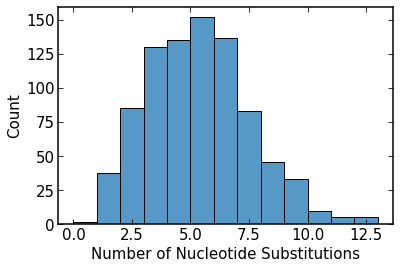

(array([  2,  38,  85, 130, 135, 152, 137,  83,  46,  33,  10,   5,   5]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13.]))

In [87]:
# Plot the per-read count of NT substitutions
mutlib.plot_hist_NT_substitutions(df_effective_AAlib)

(array([ 17,  91, 155, 165, 161, 124,  85,  35,  20,   8]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

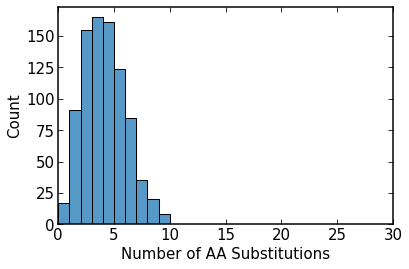

In [88]:
# Plot the per-read count of AA substitutions
mutlib.plot_hist_AA_substitutions(df_effective_AAlib)

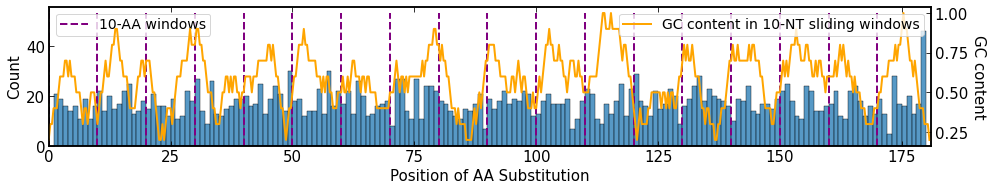

In [89]:
# Plot the per-AA position count of mutations in the library
mutlib.plot_bar_substitutions_loc(df_effective_AAlib, vline_positions= np.arange(0,180,10),wtseq=target[20:-20], GC_content=True, ntbefore=5, ntafter=5, stat='count')

In [90]:
# Print the descriptive statistics of the AA library
mutlib.descriptive_dict(df_effective_AAlib)

{'count': 861.0,
 'mean': 3.658536585365854,
 'std': 1.9009207548955114,
 'min': 0.0,
 '25%': 2.0,
 '50%': 4.0,
 '75%': 5.0,
 'max': 10.0}

/Users/anqichen/opt/anaconda3/lib/python3.9/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


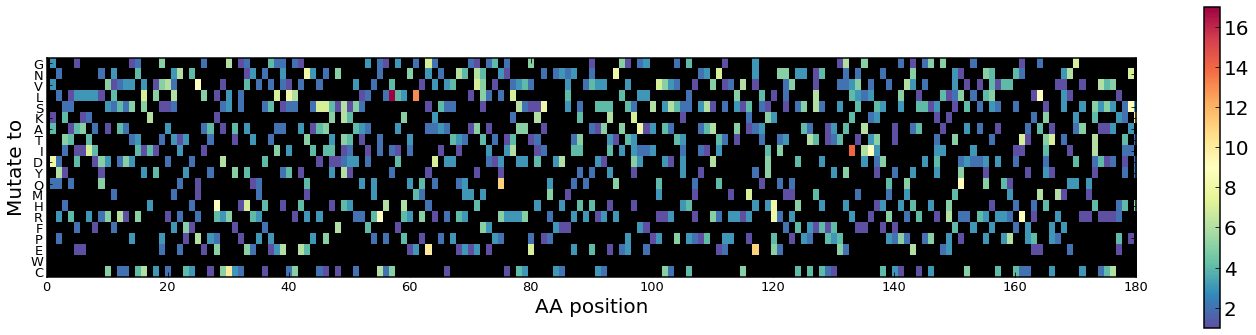

In [91]:
# Print the alignment matrix of the AA library
df_matrix_mutto_loc=mutmatrix.matrix_mutto_loc(df_effective_AAlib, target=target)
mutmatrix.plot_mut_loc_matrix(df_matrix_mutto_loc)

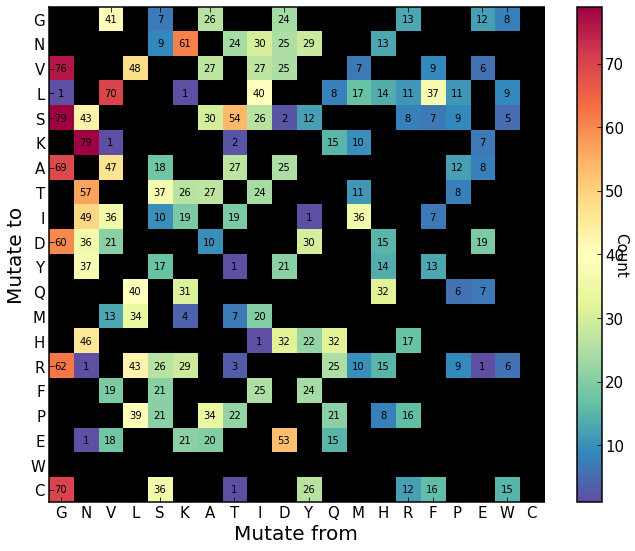

In [92]:
df_matrix_mutto_AA=mutmatrix.matrix_mutto_AA(df_matrix_mutto_loc, target)
mutmatrix.plot_matrix_mutto_AA(df_matrix_mutto_AA)

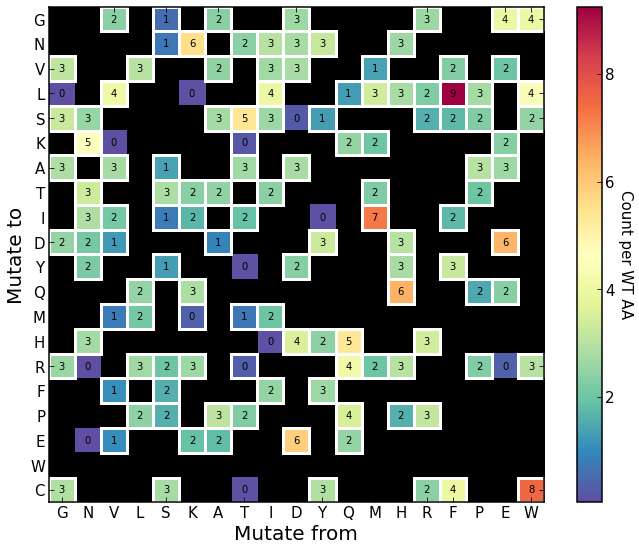

In [93]:
mutmatrix.plot_matrix_mutto_AA_norm(df_matrix_mutto_AA, target=target, theoretical_mutto_AA=np.load('theoretical epPCR AA_to_AA.npy'))

## Package left to do:
left to do:
EP_AA2AA.ipynb to generate the theoretical epPCR AA_to_AA.npy, and to generate the theoretical matrix plots

parallel code!




In [61]:
# molecular weight of plasmid
DNA_MW = 5 * 660 # kbp * 660 Da/bp
DNA_mass = 2.5 # ng
rxn_volume = 100 # ul

primer_volume = 1.5 # ul
primer_stock_conc = 10 # uM

primer_amount = primer_volume*primer_stock_conc # pmol
DNA_amount = DNA_mass/DNA_MW # pmol

In [62]:
primer_amount/DNA_amount

19800.0

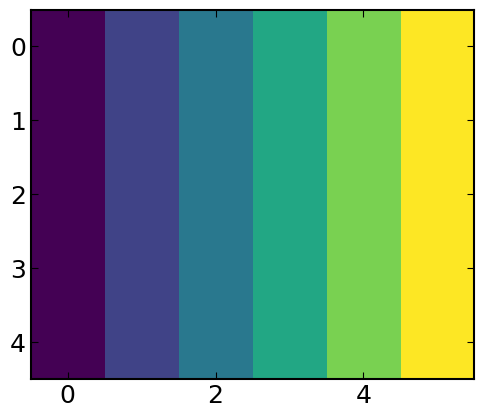

In [69]:
test_list=[]
for j in range(800,900,20):
    test_lib={}
    for i,letter in enumerate('ABCDEF'):
        test_lib[letter] = i
    test_list.append(test_lib)
test_DF = pd.DataFrame(test_list)
test_DF

plt.imshow(test_DF.to_numpy())